# Neural Network from scratch

In this lab, we will implement a simple 3-layer neural network from scratch.

In [82]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset using [scikit-learn](http://scikit-learn.org/). We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

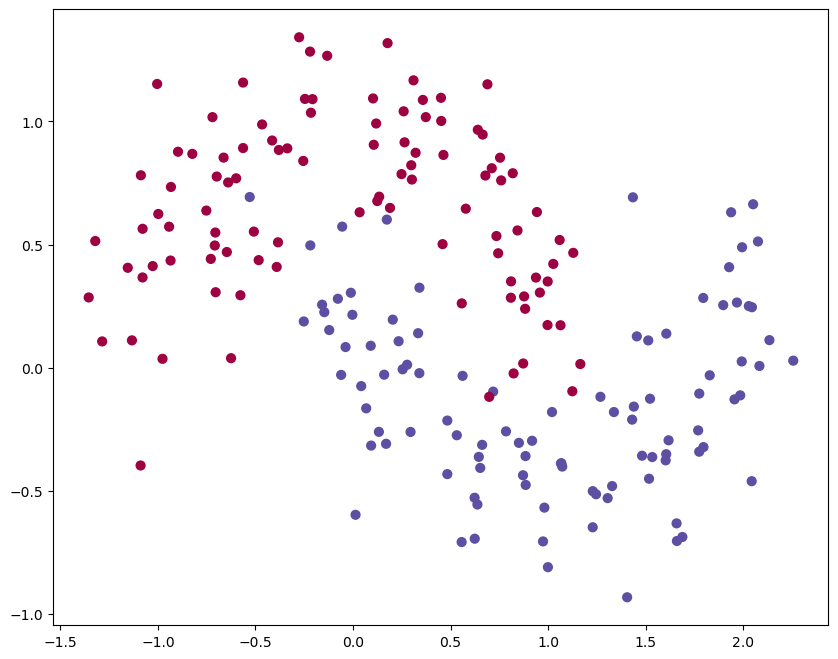

In [85]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements. 

Our goal is to train a Machine Learning classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as linear Logistic Regression, won't be able to fit the data.

## Practice 1: Logistic Regression

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). 

In [89]:
# Train the logistic regression model with l2 penalty, using 10-fold cross-validation to select the best regularization parameter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {"C": np.logspace(-3,3,7)}
## start your code here
model = LogisticRegression(penalty='l1',solver='liblinear')
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X, y)
## end your code here

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [91]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

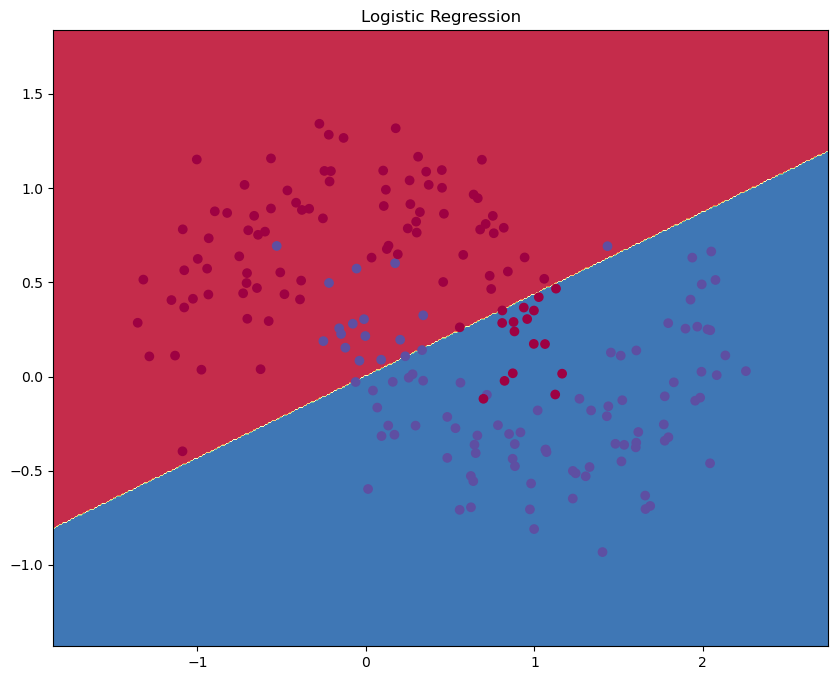

In [93]:
# Plot the decision boundary
# grid should be the trained model with the best regularization parameter
plot_decision_boundary(lambda x: grid.predict(x))
plt.title("Logistic Regression")
plt.show()

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Training a Neural Network

In [97]:
# Define some useful values
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 500 # hiddien layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [99]:
num_examples

200

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. 
* The number of nodes in the input layer is determined by the the dimension of the predictor matrix. 
* The number of nodes in the output layer is determined by the number of classes. 
* The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:


<img src='./nn-3-layer-network.png' style='width: 50%'/>

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But setting hidden layers with higher dimensionality will be easily overfitting. 

How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science. We will play with the number of nodes in the hidden layer later on and see how it affects our output.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). We will use `tanh`, which performs quite well in many scenarios. 

Because we want our network to output probabilities the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), which is simply a way to convert raw scores to probabilities. If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

#### Practice 2: Write a function for forward propagation

In [110]:
# Function to predict an output (0 or 1)
def predict(model, x):
    """
    Input: 
    * model: dictionary containing the model parameters
    * x: input data
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    ### start your code here
    # Forward propagation
    z1=x.dot(W1)+b1
    a1=np.tanh(z1)
    z2=a1.dot(W2)+b2
    exp_scores= np.exp(z2)
    probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
    prediction=np.argmax(probs,axis=1)
    ### end your code here

    return prediction,probs

In [111]:
# randomly initialize the weights, we will update them with gradient descent
np.random.seed(0)
W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
b1 = np.zeros((1, nn_hdim))
W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
b2 = np.zeros((1, nn_output_dim))

model = {}
model['W1'] = W1
model['b1'] = b1
model['W2'] = W2
model['b2'] = b2

# Forward propagation
predictions, probs = predict(model, X)
predictions[1:10] # the first 10 predictions using the randomly initialized weights
print(probs[:10]) # the first 10 probabilities using the randomly initialized weights
print(y[:10]) # the first 10 true labels

[[0.5337928  0.4662072 ]
 [0.41334765 0.58665235]
 [0.51007757 0.48992243]
 [0.47544531 0.52455469]
 [0.45423148 0.54576852]
 [0.46073435 0.53926565]
 [0.52553407 0.47446593]
 [0.47754975 0.52245025]
 [0.52636921 0.47363079]
 [0.44190361 0.55809639]]
[0 1 1 0 1 1 0 1 0 1]


In [114]:
# Tips: indexing the predicted probabilities of the true class
print(probs[range(4), y[:4]])
# Also try print(probs[:4, np.array([0,1,0,1])])

[0.5337928  0.58665235 0.48992243 0.47544531]


### Loss function

We want to minimize the *loss function* by optimizing the model parameters. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



#### Practice 3: Write a function to calculate the loss

In [118]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    
    ### start your code here
    # Forward propagation to get the predictions
    z1=X.dot(W1)+b1
    a1=np.tanh(z1)
    z2=a1.dot(W2)+b2
    exp_scores= np.exp(z2)
    probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
    # Calculating the loss
    correct_logprobs=-np.log(probs[range(num_examples),y])
    data_loss=np.sum(correct_logprobs)

    ### end your code here

    # Add regulatization term to loss (optional) and normalize the loss
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    data_loss /= num_examples
    
    return data_loss

In [120]:
loss = calculate_loss(model)
loss # your expected output

0.6529098249449039

### Learning the Parameters

We want to learn the parameters by minimizing our loss function. 

We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. There are multiple types of gradiant descent:
* batch gradient descent with a fixed learning rate (Used in this lab)
* SGD (stochastic gradient descent)
* minibatch gradient descent

More details can be learned [here](https://cs231n.github.io/neural-networks-3/#update).

#### Practice 3: Calculate derivatives

Calculate the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$ using *backpropagation algorithm*.

Hint: 
1. see example [here](http://cs231n.github.io/optimization-2/)
2. See appendix for matrix derivative


Write your answer here:
$$
\begin{aligned}

\end{aligned}
$$

#### Practice 4: Build model with backward propagation
Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [127]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        ### start your code here
        z1=X.dot(W1)+b1
        a1=np.tanh(z1)
        z2=a1.dot(W2)+b2
        exp_scores= np.exp(z2)
        probs=exp_scores/np.sum(exp_scores,axis=1,keepdims=True)
        ### end your code here

        # Backpropagation
        ### start your code here
        delta3=probs
        delta3[range(num_examples),y] -= 1
        dW2=(a1.T).dot(delta3)/num_examples
        db2=np.sum(delta3,axis=0,keepdims=True)/num_examples
        delta2=delta3.dot(W2.T)*(1-np.power(a1,2))
        dW1=np.dot(X.T,delta2)/num_examples
        db1=np.sum(delta2,axis=0,keepdims=True)/num_examples
        ### end your code here

        # Add regularization terms (optional, and b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        ### start your code here
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        ### end your code here
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.582912
Loss after iteration 1000: 0.332595
Loss after iteration 2000: 0.311568
Loss after iteration 3000: 0.306815
Loss after iteration 4000: 0.304534
Loss after iteration 5000: 0.303069
Loss after iteration 6000: 0.301871
Loss after iteration 7000: 0.300608
Loss after iteration 8000: 0.299103
Loss after iteration 9000: 0.297249
Loss after iteration 10000: 0.294981
Loss after iteration 11000: 0.292257
Loss after iteration 12000: 0.289076
Loss after iteration 13000: 0.285479
Loss after iteration 14000: 0.281548
Loss after iteration 15000: 0.277399
Loss after iteration 16000: 0.273161
Loss after iteration 17000: 0.268958
Loss after iteration 18000: 0.264898
Loss after iteration 19000: 0.261058


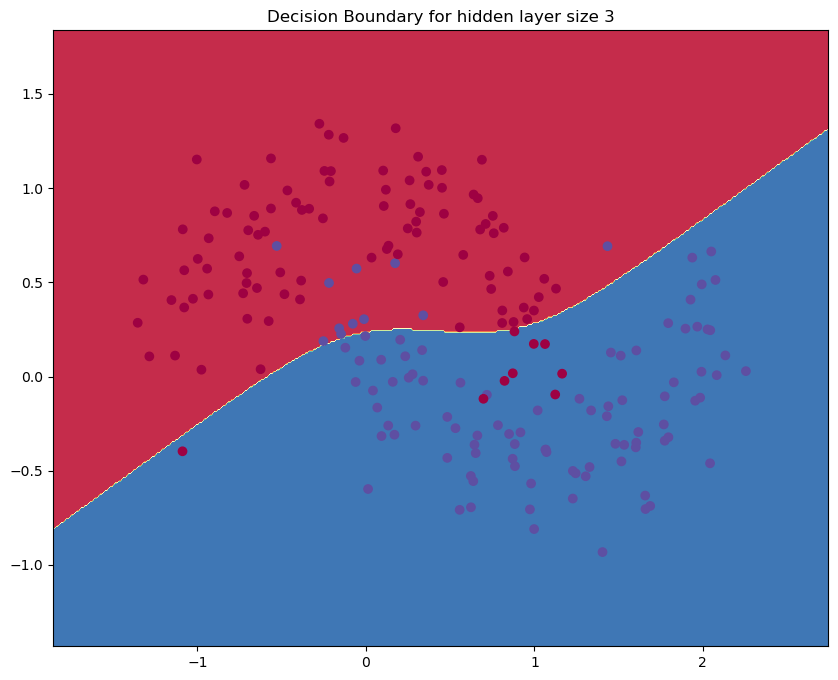

In [134]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x)[0])
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

Yay! This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


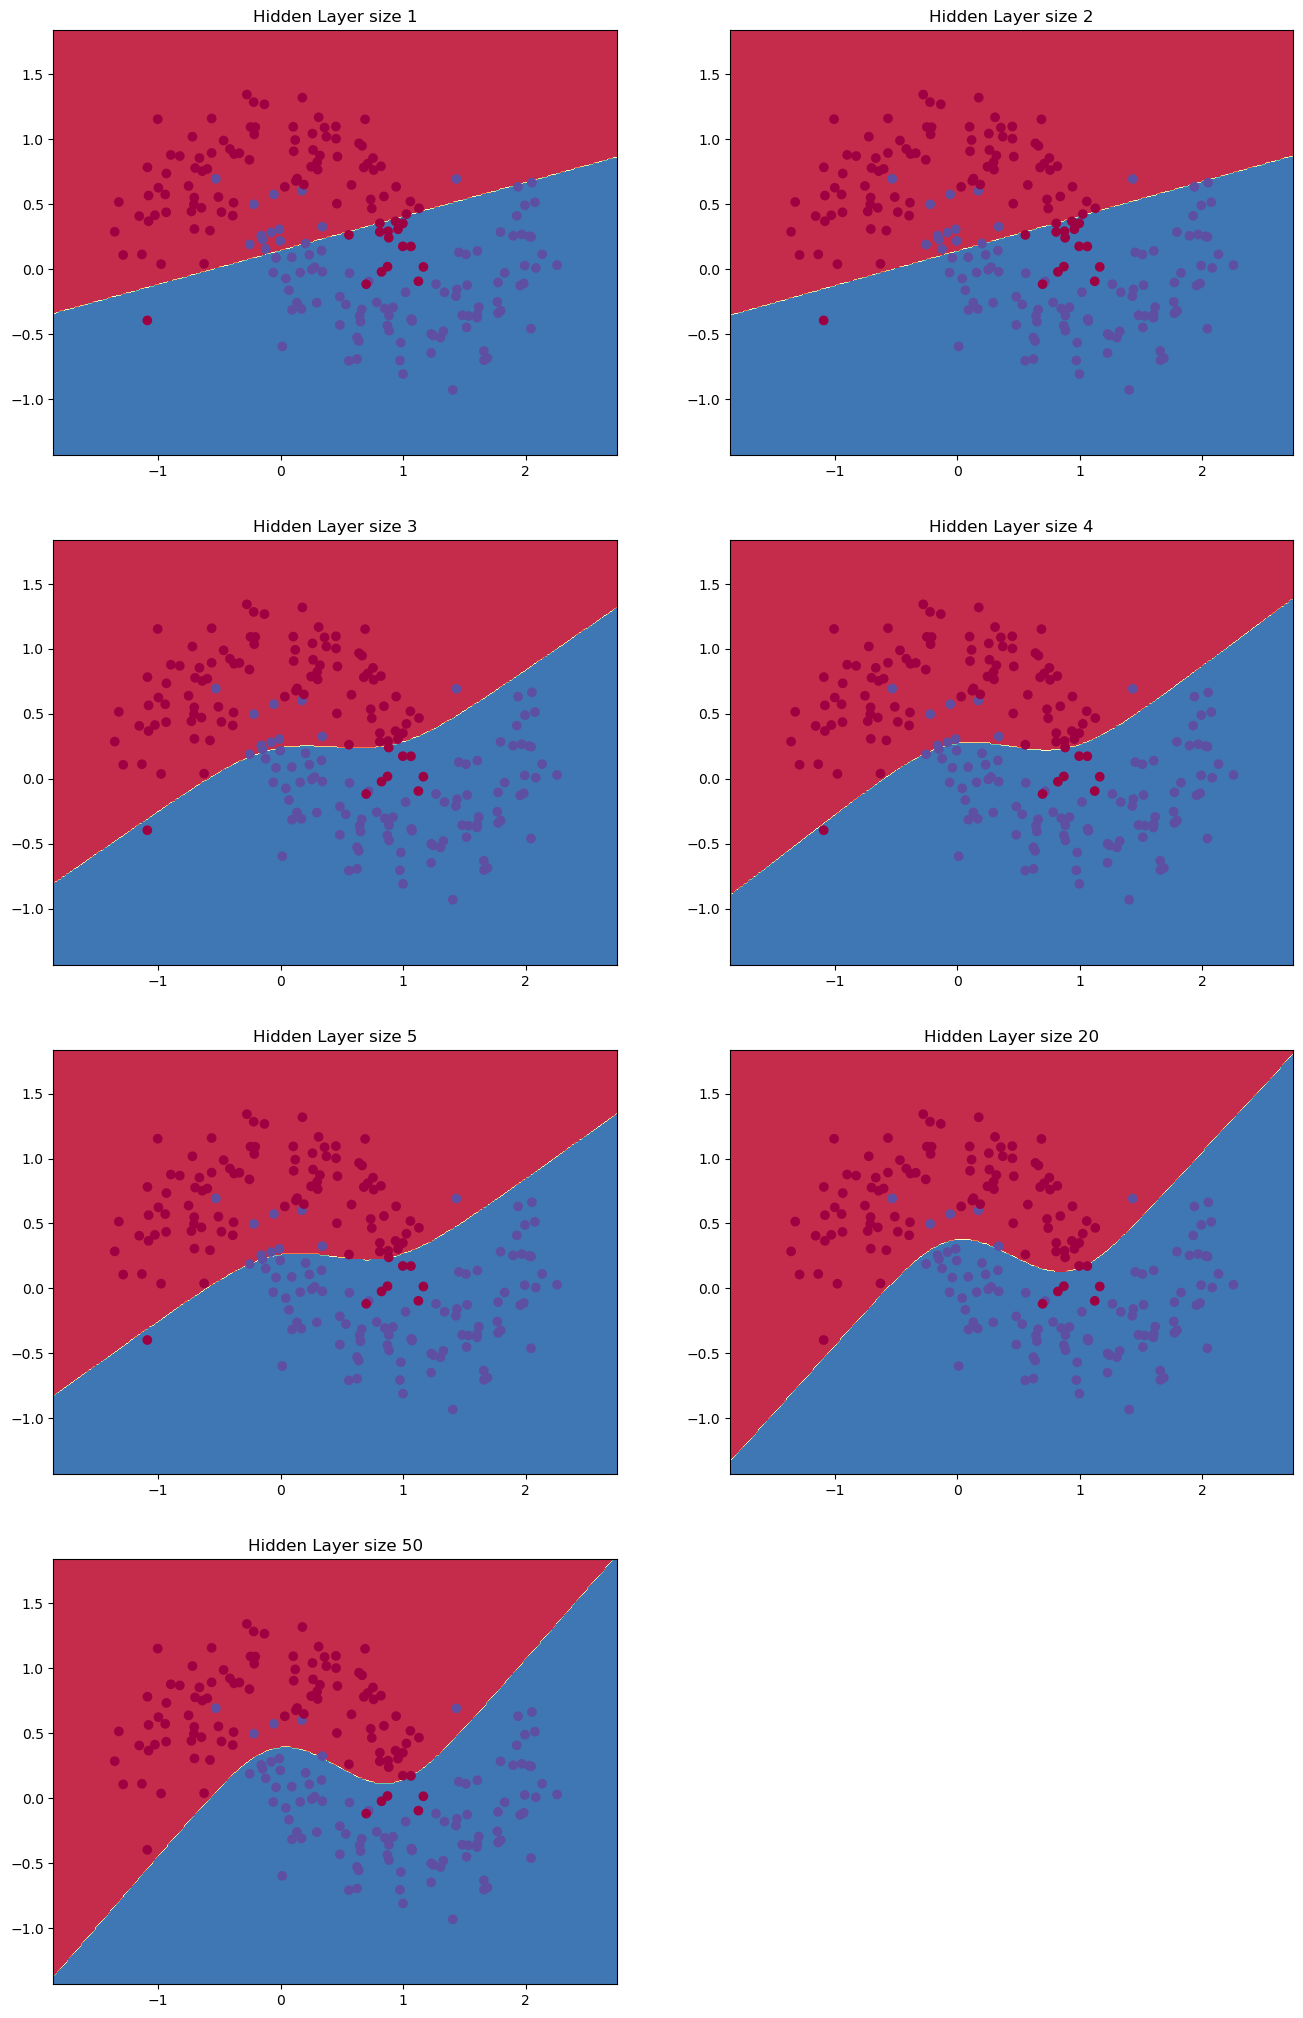

In [20]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. They are "memorizing" the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better because it generalizes better. We could counteract overfitting with stronger regularization, but picking the correct size for hidden layer is a much more "economical" solution.

# Exercises

Here are some things you can try to become more familiar with the code:

1. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). 
3. We used a $\tanh$ activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.
4. Extend the network from two to three classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.


# Appendix: Matrix derivarives: 

1. **Scalar to 2D Vector**:

   Derivative of a scalar function $f(\mathbf{x})$ with respect to a 2D vector $\mathbf{x} \in \mathbb{R}^{1\times 2}$:

   $$\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}} = 
   \begin{bmatrix}
   \frac{\partial f}{\partial x_1} \;\frac{\partial f}{\partial x_2}
   \end{bmatrix}$$

2. **2D Vector to 2D Vector**:

   Derivative of a vector function $\mathbf{f}(\mathbf{x}) \in \mathbb{R}^{1\times 2}$ with respect to a 2D vector $\mathbf{x} \in \mathbb{R}^{1\times 2}$ results in a Jacobian matrix:

   $$\frac{\partial \mathbf{f}(\mathbf{x})}{\partial \mathbf{x}} = 
   \begin{bmatrix}
   \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\
   \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2}
   \end{bmatrix}$$


3. **Linear relationship**

   Derivative of a linear vector function $\mathbf{z}=\mathbf{a}\mathbf{W}$ with respect to $\mathbf{W}$, where $a\in \mathbb{R}^{1\times d_a}$, and $W \in \mathbb{R}^{d_a\times d_z}$:

   $$\frac{\partial \mathbf{z}}{\partial \mathbf{W}}=\mathbf{a}^T$$

4. **Chain Rule for Matrix Derivatives**:

   Suppose $\mathbf{z} = f(\mathbf{y})$ and $\mathbf{y} = h(\mathbf{x})$, where $\mathbf{x} \in \mathbb{R}^{1\times d_x}, \mathbf{y}\in \mathbb{R}^{1\times d_y}, \mathbf{z} \in \mathbb{R}^{1\times d_z}$. The chain rule for derivatives is:

   $$\frac{\partial \mathbf{z}}{\partial \mathbf{x}}= \frac{\partial \mathbf{z}}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}$$

Always check the dimension!